In [51]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM


In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
 engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
 # reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [9]:
 # Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Use `engine.execute` to select and display the first 10 rows from the table

engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)
print(session.query(Measurement))
print(session.query(Station))

SELECT measurement.id AS measurement_id, measurement.station AS measurement_station, measurement.date AS measurement_date, measurement.prcp AS measurement_prcp, measurement.tobs AS measurement_tobs 
FROM measurement
SELECT station.id AS station_id, station.station AS station_station, station.name AS station_name, station.latitude AS station_latitude, station.longitude AS station_longitude, station.elevation AS station_elevation 
FROM station


# Precipitation Analysis
-  Design a query to retrieve the last 12 months of precipitation data and plot the results
-  Calculate the date 1 year ago from the last data point in the database
-  Perform a query to retrieve the data and precipitation scores
-  Save the query results as a Pandas DataFrame and set the index to the date column
-  Sort the dataframe by date
-  Use Pandas Plotting with Matplotlib to plot the data

In [12]:
# Grabs the last date entry in the data table
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


In [13]:
# to get the last 12 months of data, last date - 365
last_year = dt.date(2017,8,23) - dt.timedelta(days=365)
print(last_year)

2016-08-23


In [14]:
lastyear_prcp = (session
                        .query(Measurement.date, Measurement.prcp)
                        .filter(Measurement.date > last_year)
                        .order_by(Measurement.date)
                        .all())
lastyear_prcp_df = pd.DataFrame(lastyear_prcp, columns=["Date", "Precipitation"])
#lastyear_prcp_df.dtypes
lastyear_prcp_df["Date"] = pd.to_datetime(lastyear_prcp_df["Date"])
lastyear_prcp_df.sort_values(by=['Date'], inplace=True, ascending=False)
lastyear_prcp_df.set_index(lastyear_prcp_df["Date"], inplace = True)
lastyear_prcp_df.head()

,Date,Precipitation
Date,,
2017-08-23,2017-08-23,0.45
2017-08-23,2017-08-23,0.08
2017-08-23,2017-08-23,0.00
2017-08-23,2017-08-23,0.00
2017-08-22,2017-08-22,0.50


#### Use Pandas Plotting with Matplotlib to plot the data

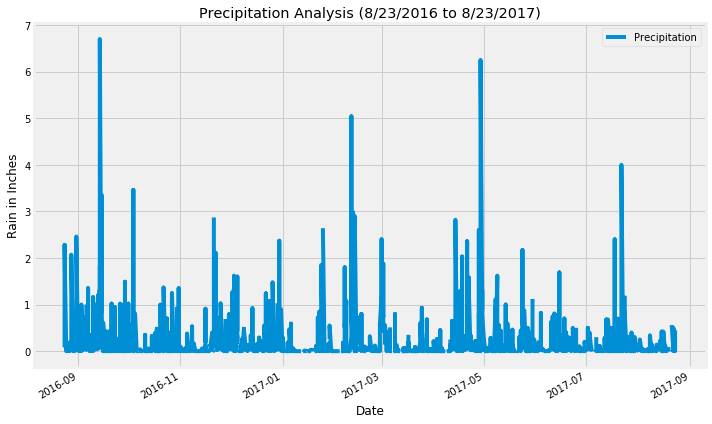

In [15]:
lastyear_prcp_df.plot('Date','Precipitation',figsize=(10,6))
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis (8/23/2016 to 8/23/2017)")
plt.legend(["Precipitation"])
# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Use Pandas to calcualte the summary statistics for the precipitation data

In [16]:
lastyear_prcp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

#### Design a query to show how many stations are available in this dataset?

In [17]:
stations = session.query(func.count(Station.id)).all()
stations

[(9)]

#### What are the most active stations? (i.e. what stations have the most rows)? List the stations and the counts in descending order.

In [18]:
most_active_station = (session
                        .query(Measurement.station, func.count(Measurement.id))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.id).desc())
                        .all())
    
print( f"The most Active Station is {most_active_station[0][0]} with {most_active_station[0][1]} weather observations.")
most_active_station

The most Active Station is USC00519281 with 2772 weather observations.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

#### Using the station id from the previous query, calculate the lowest temperature recorded, highest temperature recorded, and average temperature most active station?

In [19]:
station_records = (session
                        .query(func.min(Measurement.tobs),
                               func.max(Measurement.tobs),
                               func.avg(Measurement.tobs))
                        .filter(Measurement.station == most_active_station[0][0])
                        .all())    
    
station_records   

[(54.0, 85.0, 71.66378066378067)]

#### Choose the station with the highest number of temperature observations.Query the last 12 months of temperature observation data for this station and plot the results as a histogram

In [20]:
my_station_histogram = (session
                        .query(Measurement.date, Measurement.tobs)
                        .filter(Measurement.date > last_year, 
                                Measurement.station == most_active_station[0][0])
                        .all())  
my_station_histogram_df = pd.DataFrame(my_station_histogram, columns=["Date", "Tobs"])
my_station_histogram_df["Date"] = pd.to_datetime(my_station_histogram_df["Date"])
my_station_histogram_df.head()

,Date,Tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


#### plot the temperature data in a histogram with 12 bins

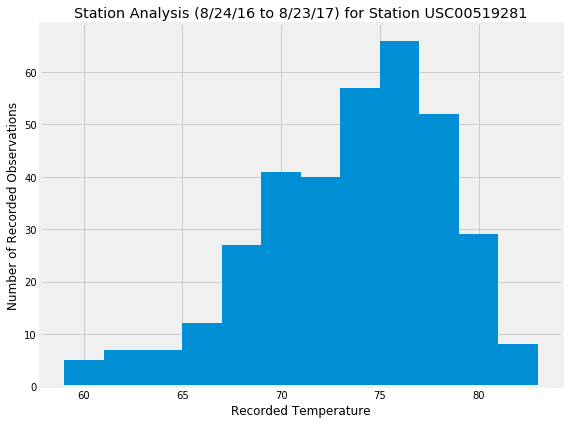

In [21]:
plt.figure(figsize=(8,6))
plt.hist(my_station_histogram_df["Tobs"],bins = 12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Number of Recorded Observations")
plt.title("Station Analysis (8/24/16 to 8/23/17) for Station " + most_active_station[0][0])
plt.tight_layout()
plt.show()

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


#### Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax for your trip using the previous year's data for those same dates.

In [23]:
trip_lastyear_start= dt.date(2018, 4, 1) - dt.timedelta(days=365)
trip_lastyear_end = dt.date(2018, 4, 15) - dt.timedelta(days=365)

temp_avg_last_year = (calc_temps(trip_lastyear_start, trip_lastyear_end))
print(temp_avg_last_year)


[(67.0, 74.47368421052632, 82.0)]


-  Plot the results from your previous query as a bar chart. 
-  Use "Trip Avg Temp" as your Title
-  Use the average temperature for the y value
-  Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

(0, 105)

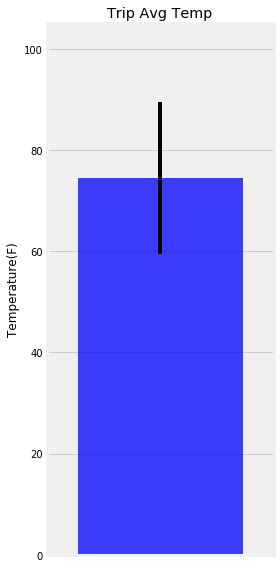

In [24]:
tmin,tavg,tmax = temp_avg_last_year[0]

error = tmax - tmin
xpos = 1
height = tavg
plt.figure(figsize=(4,8))
plt.bar(xpos,height,yerr=error,alpha = 0.75,color = "blue")
plt.xticks([])
plt.yticks(np.arange(0,120,20))
plt.ylabel("Temperature(F)")
plt.title("Trip Avg Temp")
plt.tight_layout()
plt.xlim(0.45,1.55)
plt.ylim(0,105)



#### Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates. Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

In [25]:
station_prcp_during_trip = (session
                                .query(Station.station, 
                                       Station.name, 
                                       Station.latitude, 
                                       Station.longitude, 
                                       Station.elevation,
                                       func.avg(Measurement.prcp))
                                .filter(Measurement.station == Station.station,
                                        Measurement.date.between(trip_lastyear_start,trip_lastyear_end))
                                .group_by(Station.station)
                                .order_by(func.avg(Measurement.prcp).desc()
                                        ).all())
print(station_prcp_during_trip)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.4423076923076923), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.27599999999999997), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.10933333333333332), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.075), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.02769230769230769), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.018000000000000002), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0)]


 # Optional Challenge Assignment

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

-  calculate the daily normals for your trip
-  push each tuple of calculations into a list called `normals`
-  Set the start and end date of the trip
-  Use the start and end date to create a range of dates
-  Stip off the year and save a list of %m-%d strings
-  Loop through the list of %m-%d strings and calculate the normals for each date

In [33]:
trip_lastyear_start_normal= dt.date(2018, 4, 1)
trip_lastyear_end_normal = dt.date(2018, 4, 15)


trip_dates = pd.date_range(trip_lastyear_start_normal,trip_lastyear_end_normal)

normals = [n.strftime('%m-%d') for n in trip_dates]

trip_days_temp = [daily_normals(n)[0] for n in normals]
trip_days_temp   

[(60.0, 71.87931034482759, 80.0),
 (53.0, 71.82142857142857, 79.0),
 (55.0, 72.2280701754386, 78.0),
 (58.0, 72.01639344262296, 78.0),
 (61.0, 72.28813559322033, 80.0),
 (67.0, 71.57142857142857, 77.0),
 (63.0, 71.10526315789474, 78.0),
 (66.0, 72.10526315789474, 77.0),
 (62.0, 71.6140350877193, 78.0),
 (64.0, 71.40350877192982, 79.0),
 (65.0, 72.49180327868852, 82.0),
 (65.0, 72.22413793103448, 80.0),
 (64.0, 71.52542372881356, 79.0),
 (65.0, 72.75, 81.0),
 (61.0, 71.79310344827586, 79.0)]

#### Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

In [35]:
trip_days_temp_df = pd.DataFrame(trip_days_temp,columns = ['tmin','tavg','tmax'],index=trip_dates)
trip_days_temp_df.index.name = 'date'
trip_days_temp_df

,tmin,tavg,tmax
date,,,
2018-04-01,60.0,71.879310,80.0
2018-04-02,53.0,71.821429,79.0
2018-04-03,55.0,72.228070,78.0
2018-04-04,58.0,72.016393,78.0
2018-04-05,61.0,72.288136,80.0
2018-04-06,67.0,71.571429,77.0
2018-04-07,63.0,71.105263,78.0
2018-04-08,66.0,72.105263,77.0
2018-04-09,62.0,71.614035,78.0


#### Plot the daily normals as an area plot with `stacked=False`

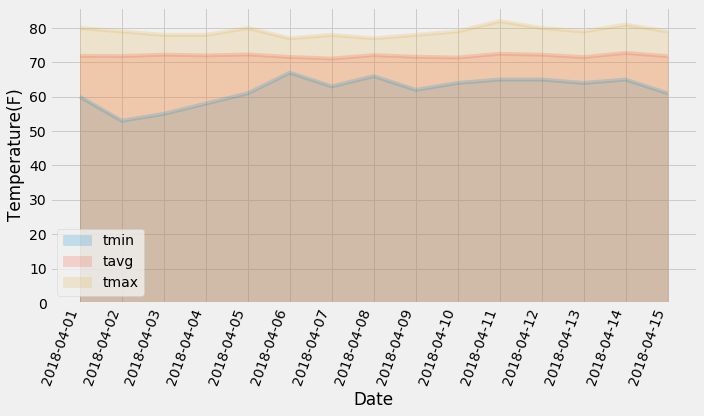

In [67]:
fig, ax = plt.subplots()

trip_days_temp_df.plot(kind = "area",stacked = False,alpha =0.2, ax=ax, figsize=(10,6))
plt.xlabel("Date")
plt.ylabel("Temperature(F)")
plt.minorticks_off()
ax.xaxis.set_ticklabels(trip_days_temp_df.index.date, rotation=70, ha='right')
ax.xaxis.set_major_locator(mdates.DayLocator())
# plt.legend(loc="best")
plt.tight_layout()
plt.show()